In [1]:
import pandas as pd
import time
import numpy as np
import struct
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import mapping
from scipy.optimize import curve_fit
import scipy.stats as st
import math
from scipy import signal

Read antpos from xlsx file in repo


In [2]:
fs=196.30822126189432 #MHz
ts=1e9/(fs*1e6) #ns

## Examine Filter

In [3]:
#coefficients copied from Matlab FDA tool
h= np.asarray([0.147691289136769848822083872619259636849,
                   -0.323933490249486866208172841652412898839,
                   -0.232672603812139389134472367004491388798,
                    0.453321166545050502350022725295275449753,
                   -0.232672603812139389134472367004491388798,
                   -0.323933490249486866208172841652412898839,
                   0.147691289136769848822083872619259636849])

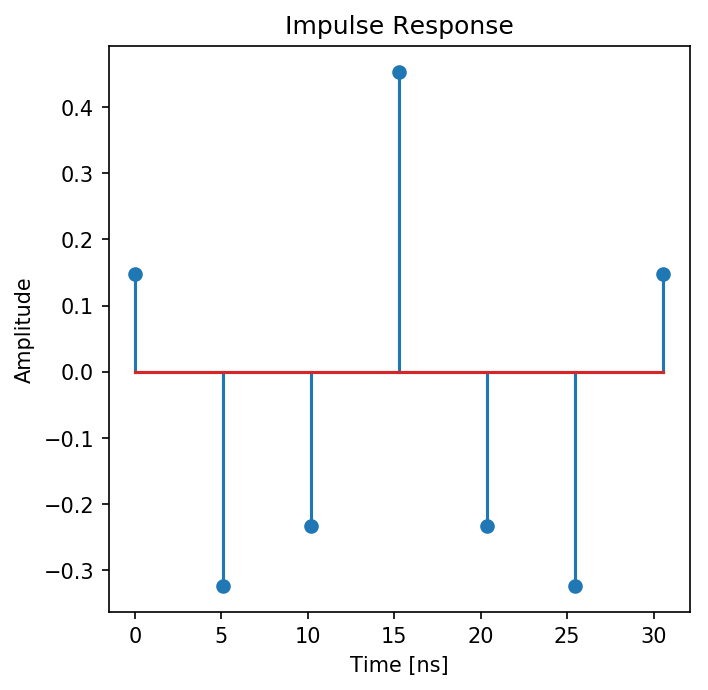

In [4]:
plt.figure(figsize=(5,5),dpi=150)
plt.stem(ts*np.asarray(range(len(h))),h)
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude")
plt.title("Impulse Response")
plt.show()

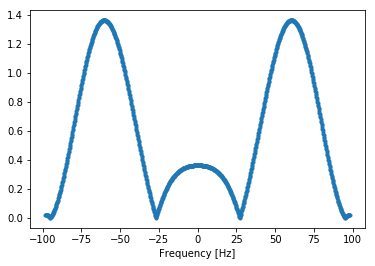

In [5]:
# plot the frequency response -- taken from the pydsr tutorial https://pysdr.org/content/filters.html
H = np.abs(np.fft.fft(h, 1024)) # take the 1024-point FFT and magnitude
H = np.fft.fftshift(H) # make 0 Hz in the center
w = np.linspace(-fs/2, fs/2, len(H)) # x axis
plt.figure('freq')
plt.plot(w, H, '.-')
plt.xlabel('Frequency [Hz]')
plt.show()

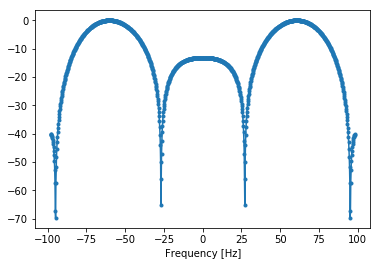

In [6]:
# plot the frequency response -- now in dB
H = np.abs(np.fft.fft(h, 1024)) # take the 1024-point FFT and magnitude
H = np.fft.fftshift(H) # make 0 Hz in the center
w = np.linspace(-fs/2, fs/2, len(H)) # x axis
plt.plot(w, 10*np.log(H/np.max(H)), '.-')
plt.xlabel('Frequency [Hz]')

plt.show()

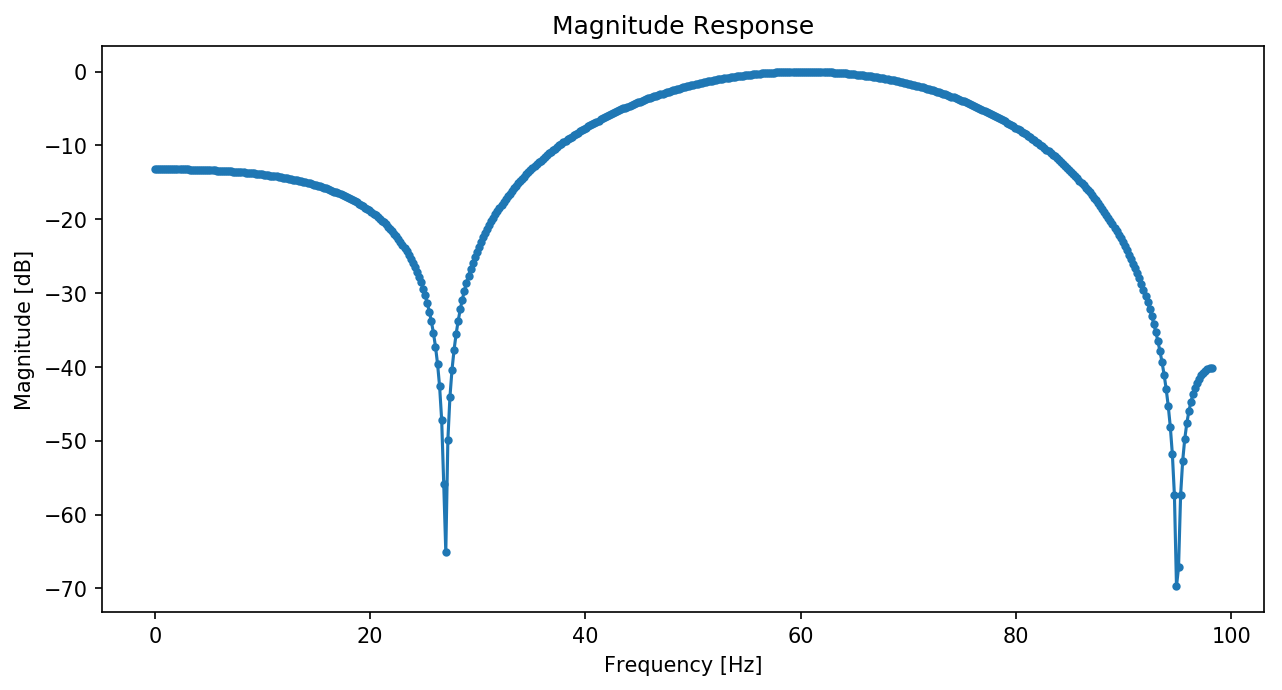

In [7]:
# plot the frequency response in dB, just the real frequencies
plt.figure(figsize=(10,5),dpi=150)

H = np.abs(np.fft.rfft(h, 1024)) # take the 1024-point FFT and magnitude
w = np.linspace(0, fs/2, len(H)) # x axis
plt.plot(w, 10*np.log(H/np.max(H)), '.-')
plt.title('Magnitude Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.show()

# Apply filter to example signals
## 1. Simulated White Noise

In [8]:
record_length=4096
rms1=30
simulated_white_noise=30*np.random.randn(record_length)
filtered=signal.convolve(h,simulated_white_noise)
print(filtered.shape)


(4102,)


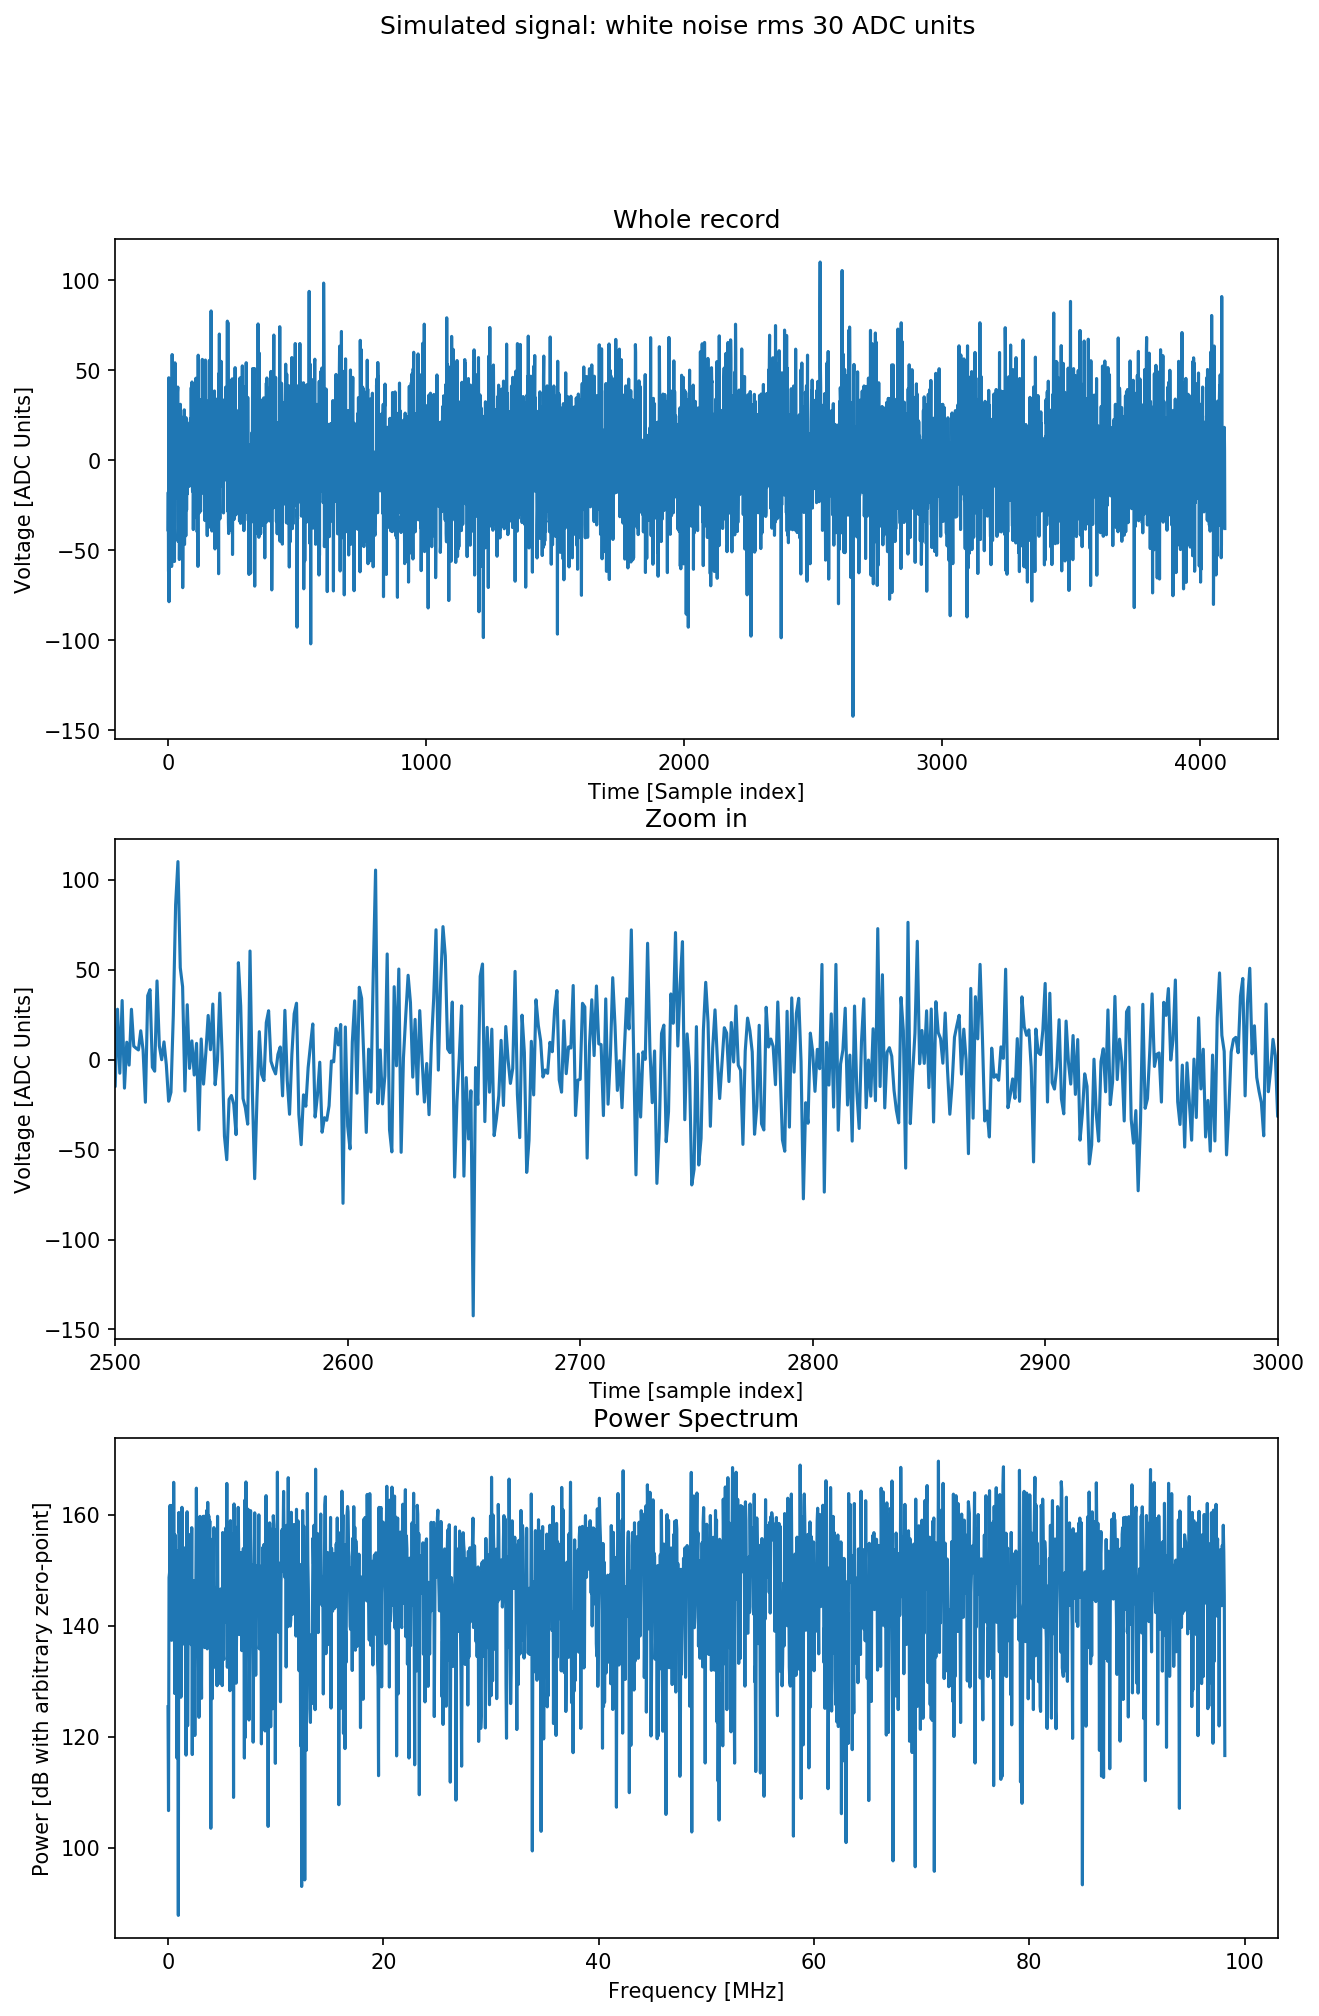

In [9]:
plt.figure(figsize=(10,15),dpi=150)
plt.suptitle("Simulated signal: white noise rms 30 ADC units")

plt.subplot(311)
plt.plot(simulated_white_noise)
plt.xlabel('Time [Sample index]')
plt.ylabel('Voltage [ADC Units]')
plt.title('Whole record')

plt.subplot(312)
plt.plot(simulated_white_noise)
plt.xlim(2500,3000)
plt.title('Zoom in')
plt.ylabel('Voltage [ADC Units]')
plt.xlabel('Time [sample index]')

plt.subplot(313)
spectrum = np.square(np.abs(np.fft.rfft(simulated_white_noise))) # take the 1024-point FFT and magnitude
f = np.linspace(0, fs/2, len(spectrum)) # x axis
plt.plot(f, 10*np.log(spectrum)) #in dB but not normalized
plt.title('Power Spectrum')
plt.ylabel('Power [dB with arbitrary zero-point]')
plt.xlabel('Frequency [MHz]')

plt.show()

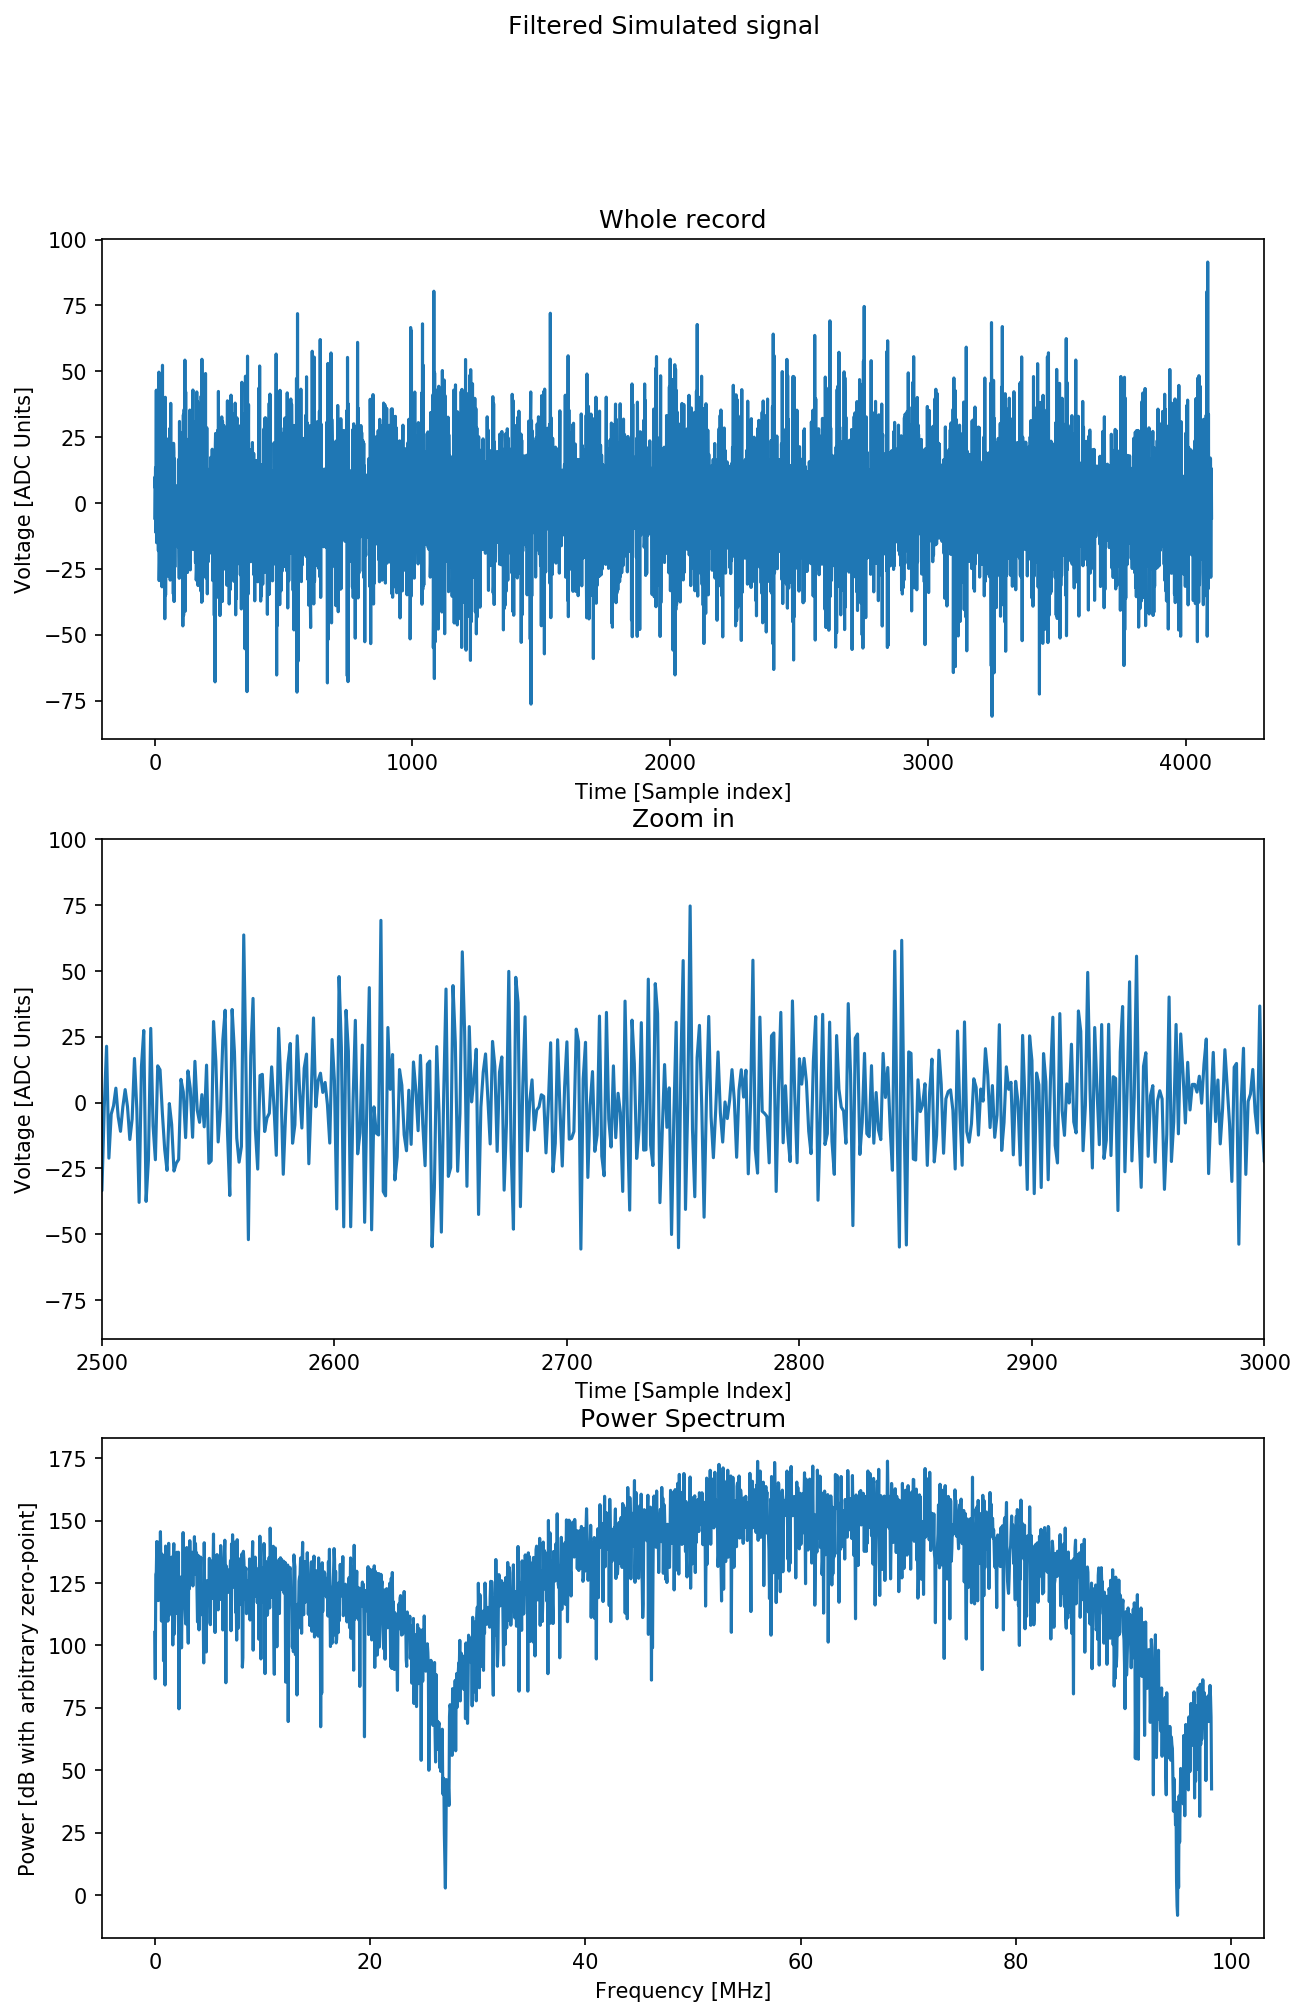

In [10]:
plt.figure(figsize=(10,15),dpi=150)
plt.suptitle("Filtered Simulated signal")

plt.subplot(311)
plt.plot(filtered)
plt.xlabel('Time [Sample index]')
plt.ylabel('Voltage [ADC Units]')
plt.title('Whole record')

plt.subplot(312)
plt.plot(filtered)
plt.xlim(2500,3000)
plt.title('Zoom in')
plt.ylabel('Voltage [ADC Units]')
plt.xlabel('Time [Sample Index]')


plt.subplot(313)
spectrum = np.square(np.abs(np.fft.rfft(filtered))) # take the 1024-point FFT and magnitude
f = np.linspace(0, fs/2, len(spectrum)) # x axis
plt.plot(f, 10*np.log(spectrum)) #in dB but not normalized
plt.title('Power Spectrum')
plt.ylabel('Power [dB with arbitrary zero-point]')
plt.xlabel('Frequency [MHz]')

plt.show()

In [11]:
print("Expected RMS of simulated signal: ",rms1)
print("Actual RMS of simulated signal: ",np.std(simulated_white_noise))
print("RMS of filtered signal: ",np.std(filtered))

Expected RMS of simulated signal:  30
Actual RMS of simulated signal:  29.919962100989657
RMS of filtered signal:  22.797711527264184


In [12]:
print(np.mean(simulated_white_noise),np.mean(filtered))

-0.12888454972904523 0.04691078961078769


## Simulated White Noise Plus a delta function

In [13]:
record_length=4096
rms1=30
simulated_record=30*np.random.randn(record_length)
simulated_record[2700]=200+simulated_record[2700]
filtered=signal.convolve(h,simulated_record)
print(filtered.shape)


(4102,)


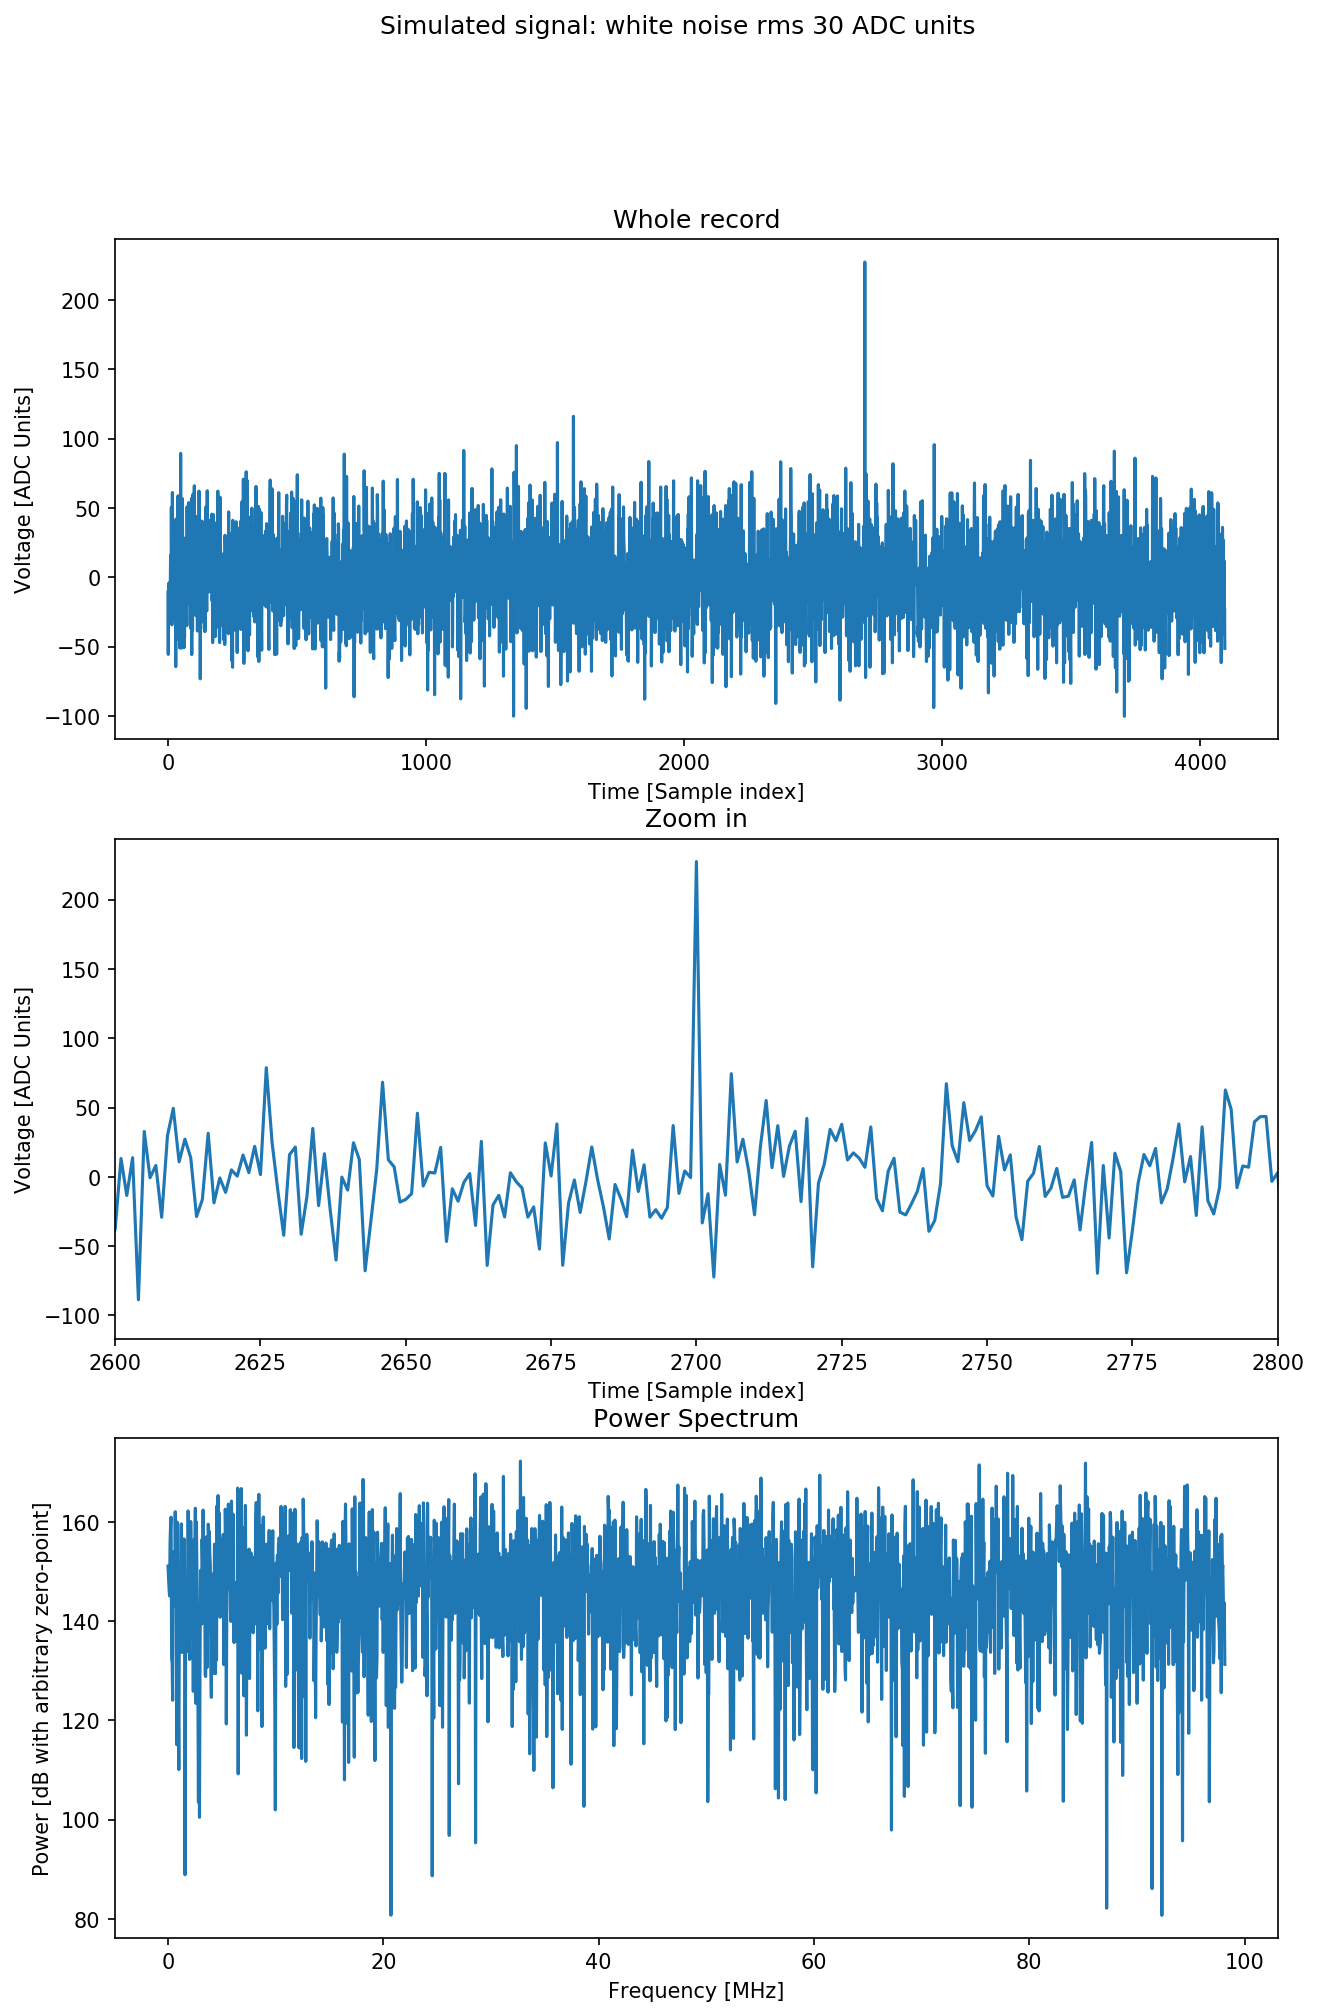

In [14]:
plt.figure(figsize=(10,15),dpi=150)
plt.suptitle("Simulated signal: white noise rms 30 ADC units")

plt.subplot(311)
plt.plot(simulated_record)
plt.xlabel('Time [Sample index]')
plt.ylabel('Voltage [ADC Units]')
plt.title('Whole record')

plt.subplot(312)
plt.plot(simulated_record)
plt.xlim(2600,2800)
plt.title('Zoom in')
plt.ylabel('Voltage [ADC Units]')
plt.xlabel('Time [Sample index]')

plt.subplot(313)
spectrum = np.square(np.abs(np.fft.rfft(simulated_record))) # take the 1024-point FFT and magnitude
f = np.linspace(0, fs/2, len(spectrum)) # x axis
plt.plot(f, 10*np.log(spectrum)) #in dB but not normalized
plt.title('Power Spectrum')
plt.ylabel('Power [dB with arbitrary zero-point]')
plt.xlabel('Frequency [MHz]')

plt.show()

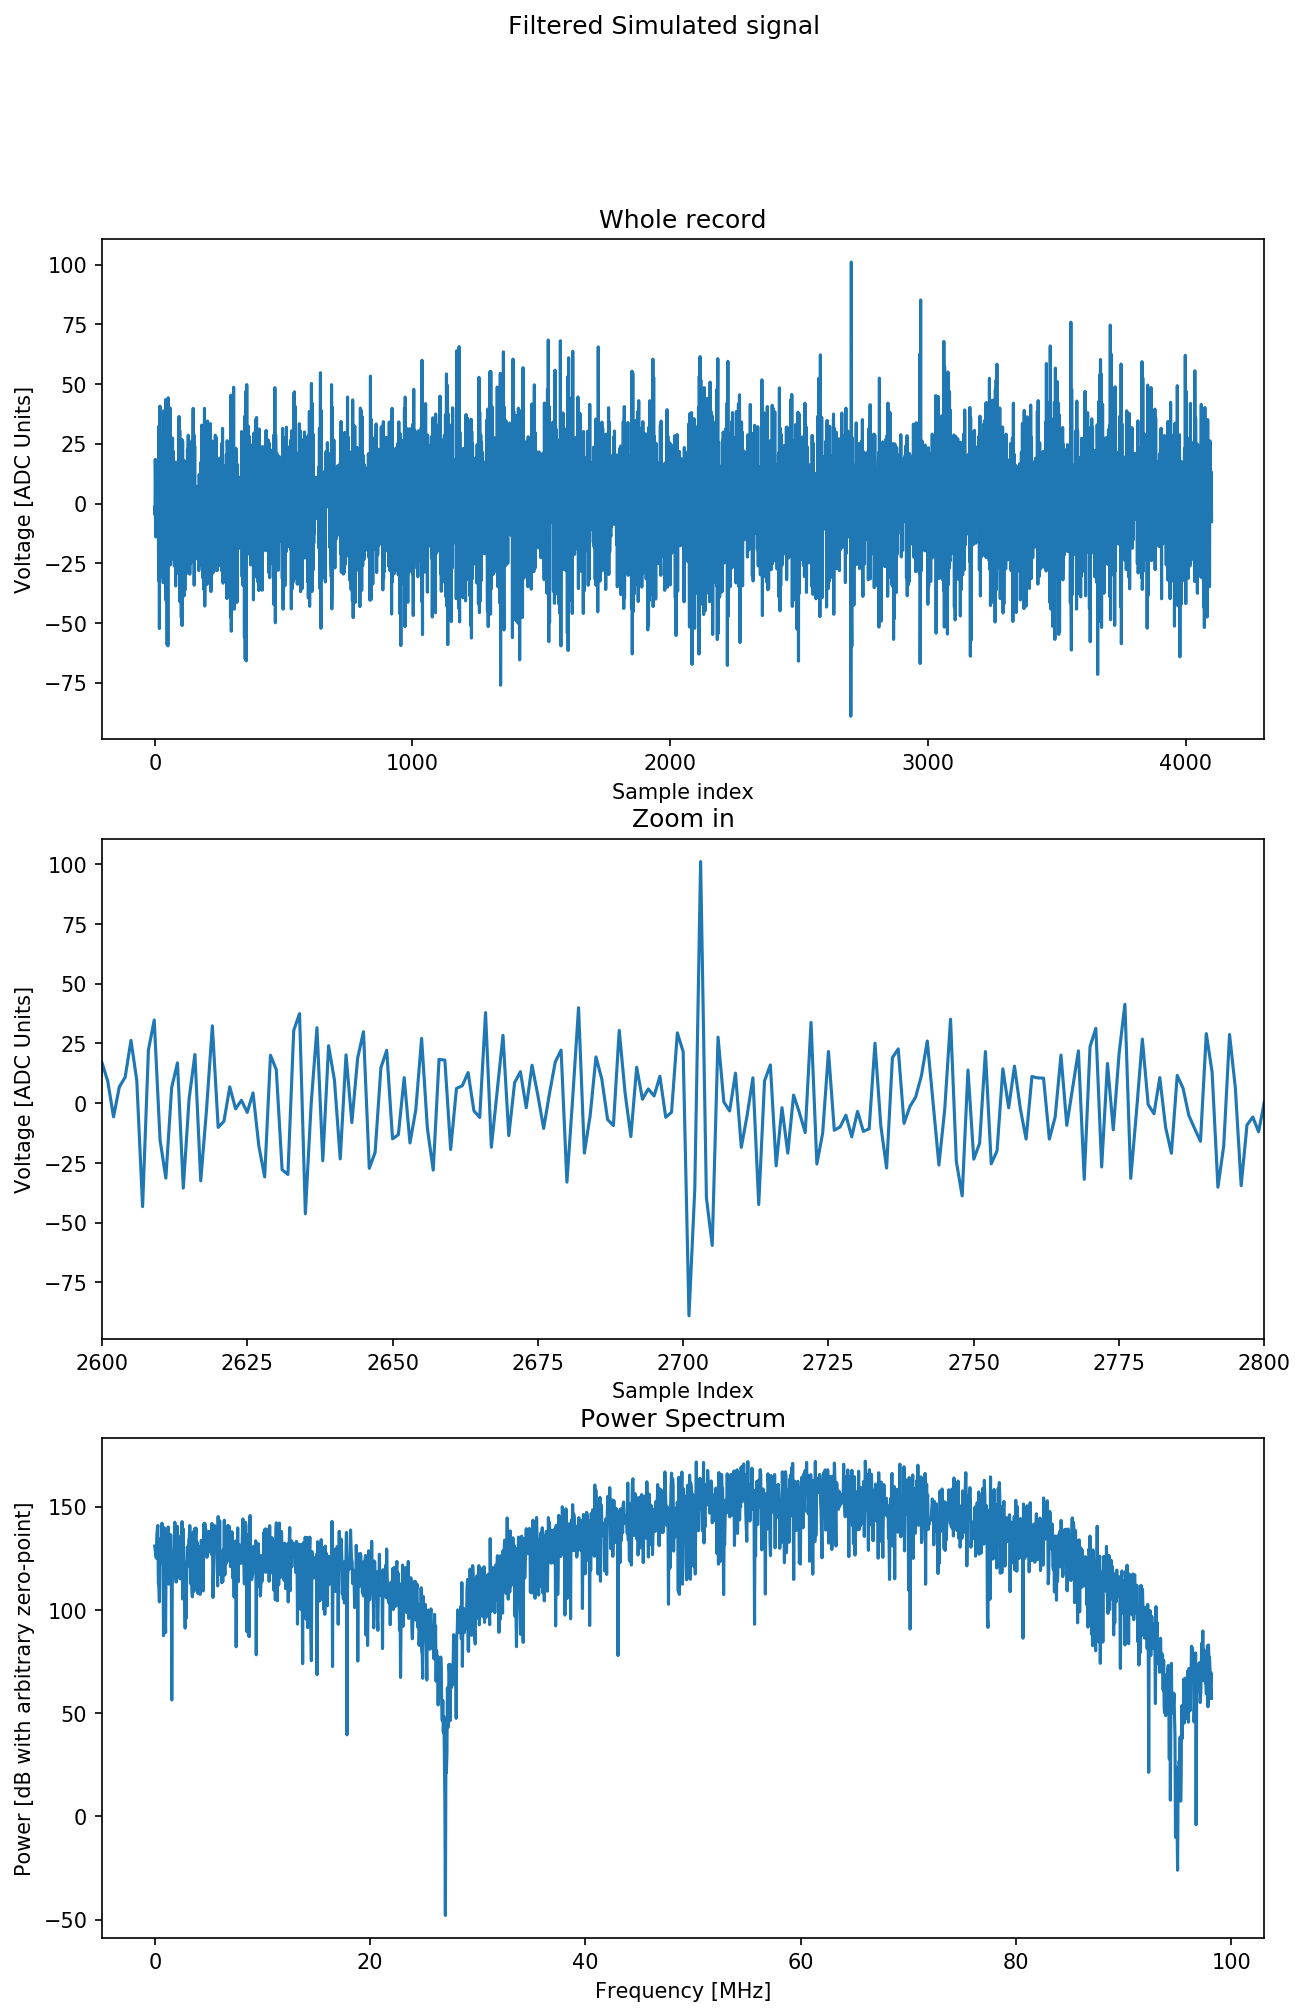

In [15]:
plt.figure(figsize=(10,15),dpi=150)
plt.suptitle("Filtered Simulated signal")

plt.subplot(311)
plt.plot(filtered)
plt.xlabel('Sample index')
plt.ylabel('Voltage [ADC Units]')
plt.title('Whole record')

plt.subplot(312)
plt.plot(filtered)
plt.xlim(2600,2800)
plt.title('Zoom in')
plt.ylabel('Voltage [ADC Units]')
plt.xlabel('Sample Index')


plt.subplot(313)
spectrum = np.square(np.abs(np.fft.rfft(filtered))) # take the 1024-point FFT and magnitude
f = np.linspace(0, fs/2, len(spectrum)) # x axis
plt.plot(f, 10*np.log(spectrum)) #in dB but not normalized
plt.title('Power Spectrum')
plt.ylabel('Power [dB with arbitrary zero-point]')
plt.xlabel('Frequency [MHz]')

plt.show()